In [1]:
import numpy as np 
import pandas as pd 
from sklearn.ensemble import RandomForestRegressor
import time 
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [ ]:
0.12 altına düşülecek

In [56]:
trainData = pd.read_csv("train.csv")
testData = pd.read_csv("test.csv")

del trainData["Id"],testData["Id"] 

trainPrices = trainData["SalePrice"].to_numpy()

del trainData["Alley"],testData["Alley"]

print(trainData.shape,testData.shape)
#trainData.replace(np.nan, 0,inplace = True)
#testData.replace(np.nan, 0,inplace = True)

(1460, 79) (1459, 78)


<AxesSubplot:>

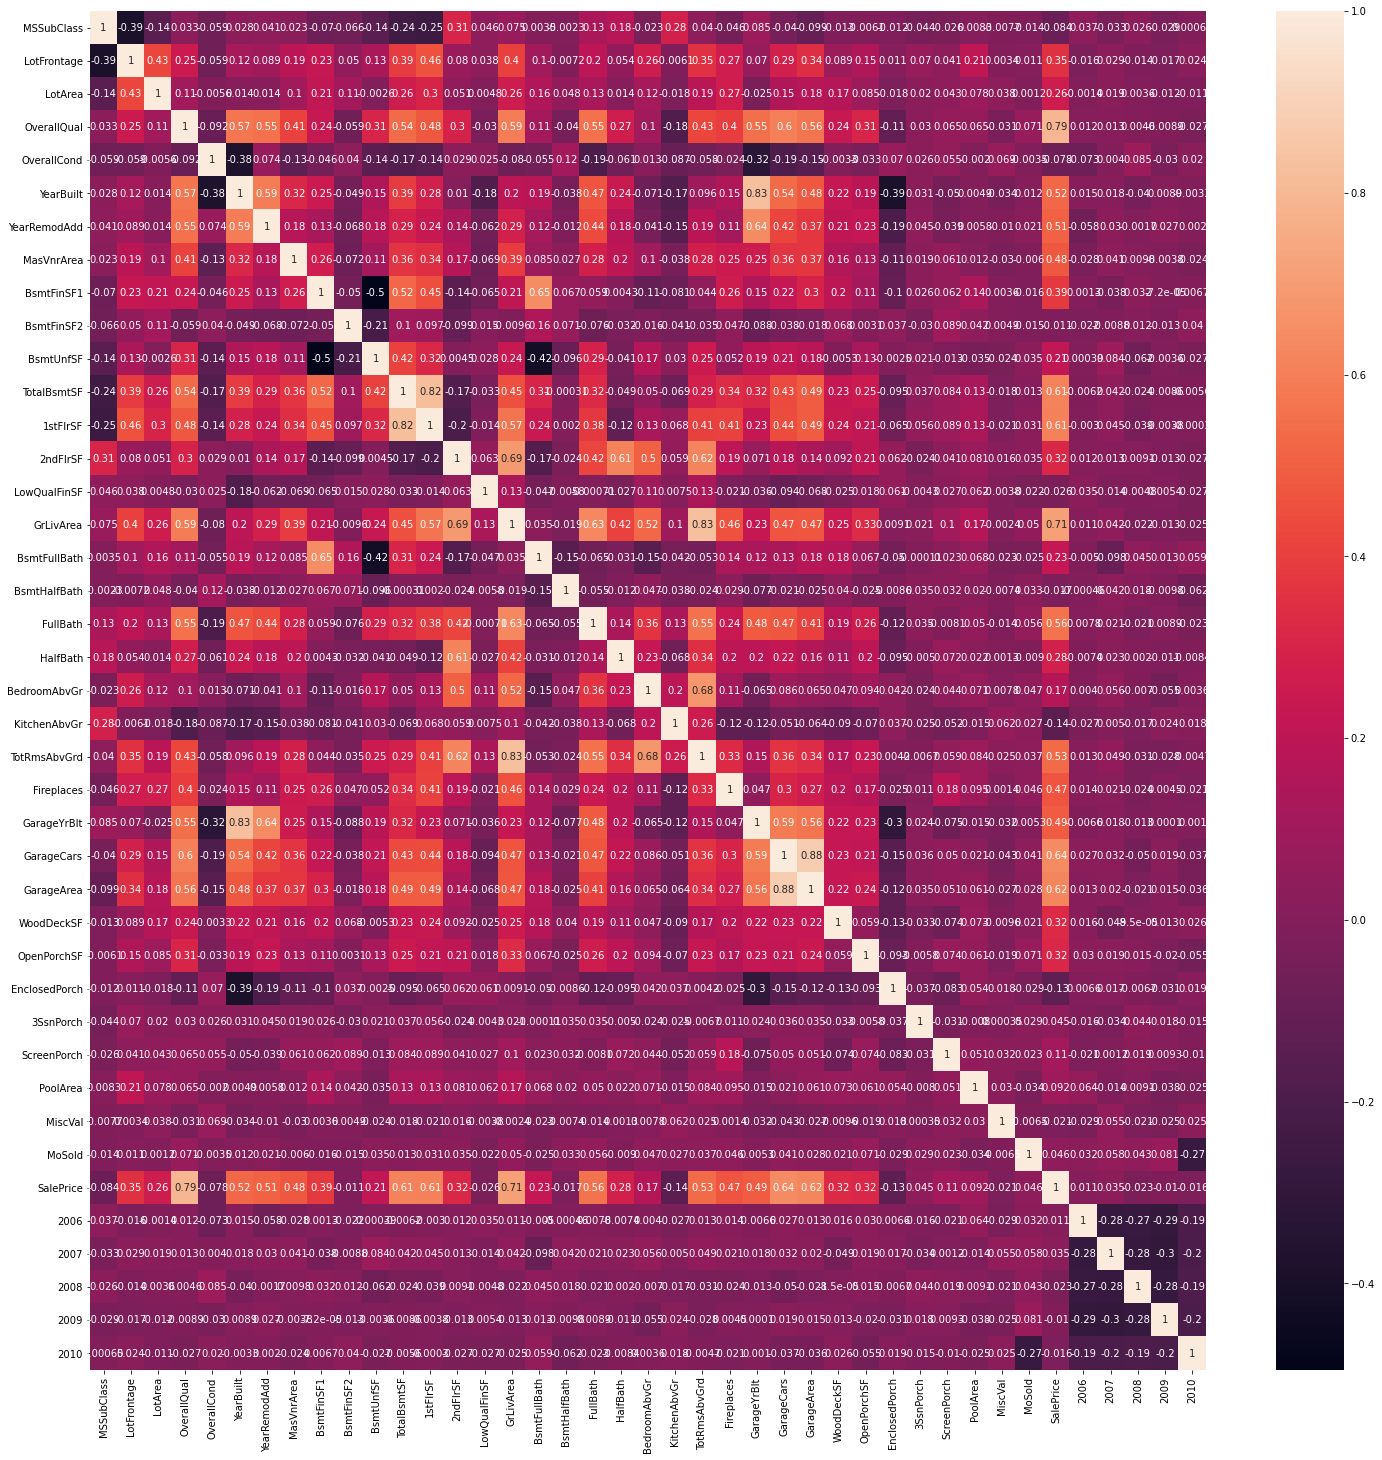

In [60]:
plt.figure(figsize=(25,25))
sns.heatmap(trainData.corr(),annot=True)

In [46]:
dropCols=trainData.columns[np.where((trainData.corr()["SalePrice"].to_numpy()[:-1]<0.2)&(trainData.corr()["SalePrice"].to_numpy()[:-1]>-0.2))]

In [47]:
del trainData["SalePrice"]

In [48]:
trainData.drop(columns=dropCols,inplace=True)
testData.drop(columns=dropCols,inplace=True)

In [49]:
numNC = trainData.isnull().sum().to_numpy()
#trainData.drop(trainData.columns[np.where((numNC > 200))],axis =1 ,inplace =  True)
testData.drop(testData.columns[np.where((numNC > 200)&(trainData.dtypes!=np.float64))],axis =1 ,inplace =  True)
trainData.drop(trainData.columns[np.where((numNC > 200)&(trainData.dtypes!=np.float64))],axis =1 ,inplace =  True)
print(trainData.shape,testData.shape)

(1460, 60) (1459, 60)


In [50]:
trainData.isnull().sum().to_numpy()

array([  0, 259,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   8,   8,   0,   0,   0,  37,   0,   0,   0,   0,
         1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,  81,  81,  81,   0,   0,  81,  81,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0])

In [51]:
trainData.head()

,MSZoning,LotFrontage,LotArea,LotShape,LandContour,Utilities,LotConfig,Neighborhood,Condition1,Condition2,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,RL,65.0,8450,Reg,Lvl,AllPub,Inside,CollgCr,Norm,Norm,...,61,0,0,0,0,0,2,2008,WD,Normal
1,RL,80.0,9600,Reg,Lvl,AllPub,FR2,Veenker,Feedr,Norm,...,0,0,0,0,0,0,5,2007,WD,Normal
2,RL,68.0,11250,IR1,Lvl,AllPub,Inside,CollgCr,Norm,Norm,...,42,0,0,0,0,0,9,2008,WD,Normal
3,RL,60.0,9550,IR1,Lvl,AllPub,Corner,Crawfor,Norm,Norm,...,35,272,0,0,0,0,2,2006,WD,Abnorml
4,RL,84.0,14260,IR1,Lvl,AllPub,FR2,NoRidge,Norm,Norm,...,84,0,0,0,0,0,12,2008,WD,Normal


In [52]:
trainData["YrSold"].unique()

array([2008, 2007, 2006, 2009, 2010])

In [53]:
dummies = pd.get_dummies(trainData["YrSold"], drop_first = False)
trainData = pd.concat([trainData,dummies],axis=1)
del trainData["YrSold"]

In [54]:
trainData.head()

,MSZoning,LotFrontage,LotArea,LotShape,LandContour,Utilities,LotConfig,Neighborhood,Condition1,Condition2,...,PoolArea,MiscVal,MoSold,SaleType,SaleCondition,2006,2007,2008,2009,2010
0,RL,65.0,8450,Reg,Lvl,AllPub,Inside,CollgCr,Norm,Norm,...,0,0,2,WD,Normal,0,0,1,0,0
1,RL,80.0,9600,Reg,Lvl,AllPub,FR2,Veenker,Feedr,Norm,...,0,0,5,WD,Normal,0,1,0,0,0
2,RL,68.0,11250,IR1,Lvl,AllPub,Inside,CollgCr,Norm,Norm,...,0,0,9,WD,Normal,0,0,1,0,0
3,RL,60.0,9550,IR1,Lvl,AllPub,Corner,Crawfor,Norm,Norm,...,0,0,2,WD,Abnorml,1,0,0,0,0
4,RL,84.0,14260,IR1,Lvl,AllPub,FR2,NoRidge,Norm,Norm,...,0,0,12,WD,Normal,0,0,1,0,0


<AxesSubplot:>

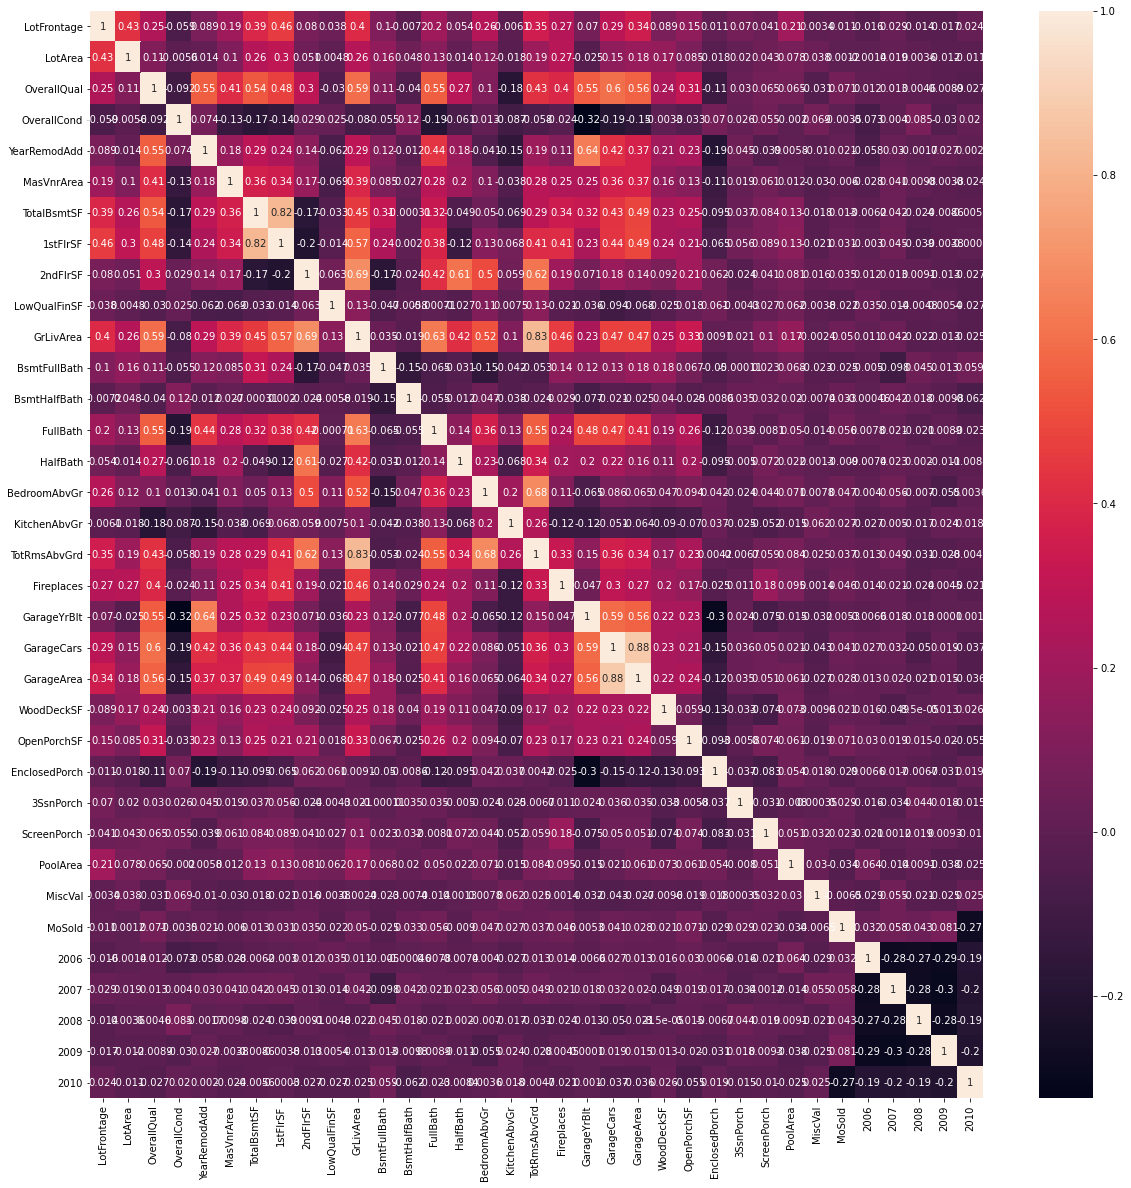

In [55]:
plt.figure(figsize=(20,20))
sns.heatmap(trainData.corr(),annot=True)

In [115]:
s=time.time()
numNR = trainData.isnull().sum()
print(np.sum(numNR.to_numpy()))
mostCommons = trainData.value_counts().idxmax()
counter = 0
for i in range(trainData.shape[0]):
    numNR = trainData.loc[i].isnull().sum()
    nullFeatures = trainData.loc[i].isnull().to_numpy()
    if numNR > 0:
        curPrice = trainPrices[i]
        priceDif = abs(trainPrices-curPrice)
        #closestIndex = np.where(priceDif == np.min(priceDif))
        closestIndex = np.where(priceDif < curPrice*0.1)
        for j in range(nullFeatures.shape[0]):
            if nullFeatures[j] == True:
                rowss=trainData.loc[closestIndex].iloc[:,j]
                rowss.dropna( inplace=True)
                if rowss.shape[0] >0:
                    if rowss.dtype != object:
                        meann = np.mean(rowss)
                        trainData.iloc[i,j] = meann
                        counter = counter+1
                    else:
                        npIsEasier = rowss.to_numpy()
                        maxOccur = np.argmax(npIsEasier)
                        trainData.iloc[i,j] = npIsEasier[maxOccur]
                        counter = counter+1
                else:
                    trainData.iloc[i,j] = mostCommons[j]
numNR = trainData.isnull().sum()
print(np.sum(numNR.to_numpy()))
print(time.time()-s)  

718
0
0.5736849308013916


In [116]:
numNR = testData.isnull().sum()
print(np.sum(numNR.to_numpy()))
counter = 0
mostCommons = trainData.value_counts().idxmax()
for i in range(testData.shape[0]):
    numNR = testData.loc[i].isnull().sum()
    nullFeatures = testData.loc[i].isnull().to_numpy()
    if numNR > 0:
        for j in range(nullFeatures.shape[0]):
            if nullFeatures[j] == True:
                testData.iloc[i,j] = mostCommons[j]
numNR = testData.isnull().sum()
print(np.sum(numNR.to_numpy()))

708
0


In [117]:
#trainData.replace(np.nan, 0,inplace = True)
#testData.replace(np.nan, 0,inplace = True)

In [118]:
allData = pd.concat([trainData,testData])

In [119]:
col_names = list(allData.columns.values)
encodePlz = [ col  for col, dt in allData.dtypes.items() if dt == object]

dummies = pd.get_dummies(allData[encodePlz], prefix=encodePlz)
allData= allData.drop(encodePlz,axis=1)

In [120]:
allData = pd.concat([allData,dummies],axis=1)

In [121]:
print(trainData.shape[0]+testData.shape[0],allData.shape[0])

2919 2919


In [122]:
trainFeatures = allData[:trainData.shape[0]].to_numpy()

In [123]:
split_decimal = 0.95
xTrain = trainFeatures[:int(trainFeatures.shape[0]*split_decimal)] 
yTrain = trainPrices[:int(trainPrices.shape[0]*split_decimal)] 

xTest = trainFeatures[int(trainFeatures.shape[0]*split_decimal):] 
yTest =trainPrices[int(trainPrices.shape[0]*split_decimal):] 
print(xTrain.shape,yTrain.shape)
print(xTest.shape,yTest.shape)

(1387, 180) (1387,)
(73, 180) (73,)


In [197]:
normxTrain=(xTrain-np.min(trainFeatures,axis=0))/(np.max(trainFeatures,axis=0)-np.min(trainFeatures,axis=0))
normxTest=(xTest-np.min(trainFeatures,axis=0))/(np.max(trainFeatures,axis=0)-np.min(trainFeatures,axis=0))

In [223]:
forModel = RandomForestRegressor(max_depth=10,random_state=0)
forModel.fit(normxTrain, yTrain)

RandomForestRegressor(max_depth=10, random_state=0)

In [224]:
forModel.score(normxTest,yTest)

0.9090717086743729

In [225]:
testPreds=forModel.predict(normxTest)

In [226]:
predFeatures = allData[trainData.shape[0]:].to_numpy()
print(predFeatures.shape)

(1459, 180)


In [227]:
normPredFeatures =(predFeatures-np.min(trainFeatures,axis=0))/(np.max(trainFeatures,axis=0)-np.min(trainFeatures,axis=0))
predictions = forModel.predict(normPredFeatures)

In [228]:
predictions[0]

124704.5712167996

In [229]:
predictions = pd.DataFrame({'Id': list(range(1461,1461+1459,1)), 'SalePrice': predictions})
predictions.to_csv('submission2.csv', index=False)

In [230]:
predictions.head()

,Id,SalePrice
0,1461,124704.571217
1,1462,154165.888726
2,1463,169898.958264
3,1464,178982.381852
4,1465,201218.442151


In [231]:
import tensorflow as tf
m = tf.keras.metrics.RootMeanSquaredError()

In [232]:
m.reset_state()
m.update_state(np.log(yTest),np.log(testPreds))
m.result().numpy()

0.121197574